#📌 Extracción

# =========================================
#  EXTRACCIÓN
#  - Monta Drive y lee el JSON
#  - Aplana el JSON si viene anidado
# =========================================

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE_PATH = "/content/drive/MyDrive/proyecto_telecomx_parte1/TelecomX_Data.json"

# Lee el JSON a DataFrame
raw = pd.read_json(FILE_PATH)

# Aplana registros anidados a columnas "con puntos", ej: account.Charges.Total
df = pd.json_normalize(raw.to_dict('records'), sep='.')

print("Filas x columnas:", df.shape)
df.info()

Mounted at /content/drive
Filas x columnas: (7267, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object

# =========================================
#  TRANSFORMACIÓN
#  - Tipos correctos y limpieza mínima
#  - Imputación coherente de Total
#  - Variable diaria y objetivo binario
#  - Estandarización ligera de categóricas
# =========================================

In [2]:
# ID como texto "real"
df['customerID'] = df['customerID'].astype('string')

# Cargos totales a numérico (coerce => convierte inválidos a NaN)
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Imputación mínima y explicable:
# - Si tenure=0 => Total=0 (cliente nuevo)
# - Si tenure>0 => Total ≈ Monthly * tenure
na_total = df['account.Charges.Total'].isna()
df.loc[na_total & (df['customer.tenure'] == 0), 'account.Charges.Total'] = 0
df.loc[na_total & (df['customer.tenure'] > 0),  'account.Charges.Total'] = \
    df.loc[na_total, 'account.Charges.Monthly'] * df.loc[na_total, 'customer.tenure']

# Variable objetivo binaria (1=churn "yes", 0=no)
df['Churn_bin'] = df['Churn'].astype(str).str.strip().str.lower().eq('yes').astype(int)

# Cuentas diarias a partir de la facturación mensual (mes promedio = 365.25/12)
days_per_month = 365.25 / 12   # 30.4375 días
df['Cuentas_Diarias'] = df['account.Charges.Monthly'].fillna(0) / days_per_month

# Estandariza y tipa las categóricas clave (limpia espacios/case y usa 'category')
cat_cols = [
    'Churn','customer.gender','customer.Partner','customer.Dependents',
    'phone.PhoneService','phone.MultipleLines','internet.InternetService',
    'internet.OnlineSecurity','internet.OnlineBackup','internet.DeviceProtection',
    'internet.TechSupport','internet.StreamingTV','internet.StreamingMovies',
    'account.Contract','account.PaperlessBilling','account.PaymentMethod'
]
existing_cat = [c for c in cat_cols if c in df.columns]
df[existing_cat] = (df[existing_cat]
                    .astype('string')
                    .apply(lambda s: s.str.strip().str.lower())
                    .astype('category'))

# Chequeos rápidos (explicación: confirma salud de datos antes del análisis)
print("\nNulos por columna (top 5):")
print(df.isna().sum().sort_values(ascending=False).head(5))
print("\nDuplicados por customerID:", df.duplicated('customerID').sum())



Nulos por columna (top 5):
customerID                0
Churn                     0
customer.gender           0
customer.SeniorCitizen    0
customer.Partner          0
dtype: int64

Duplicados por customerID: 0


# =========================================
#  CARGA Y ANÁLISIS
#  - Descriptivos numéricos (global y por churn)
#  - Distribución global de churn
#  - Churn por categórica (tasa y composición)
#  - Numéricas por churn (hist/boxplot)
# =========================================


Resumen churn (conteo y %):
            Clientes      %
Permanecen      5398  74.28
Churn           1869  25.72


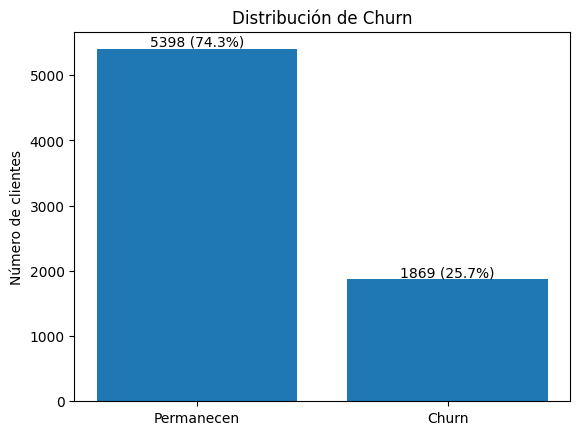

,% churn
account.Contract,
month-to-month,41.3
one year,10.9
two year,2.8


Churn_bin,Permanecen,Churn
account.Contract,,
month-to-month,58.7,41.3
one year,89.1,10.9
two year,97.2,2.8


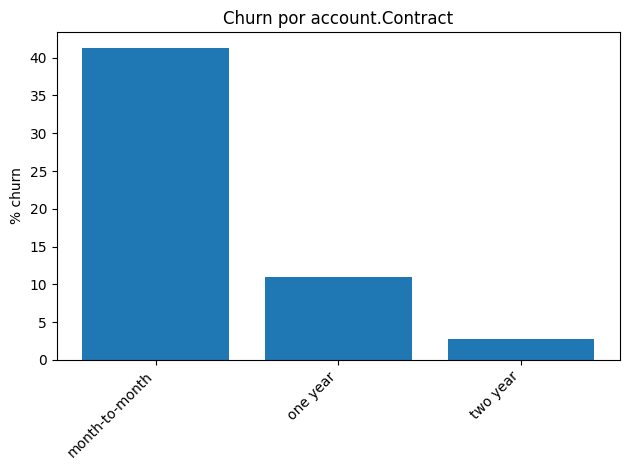

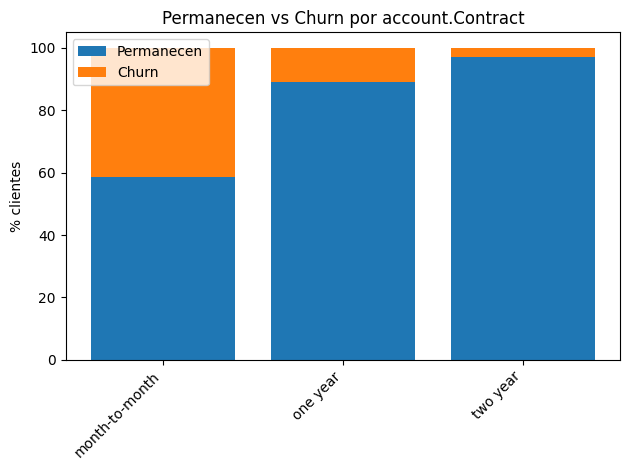

,% churn
account.PaymentMethod,
electronic check,43.8
mailed check,18.5
bank transfer (automatic),16.2
credit card (automatic),14.8


Churn_bin,Permanecen,Churn
account.PaymentMethod,,
bank transfer (automatic),83.8,16.2
credit card (automatic),85.2,14.8
electronic check,56.2,43.8
mailed check,81.5,18.5


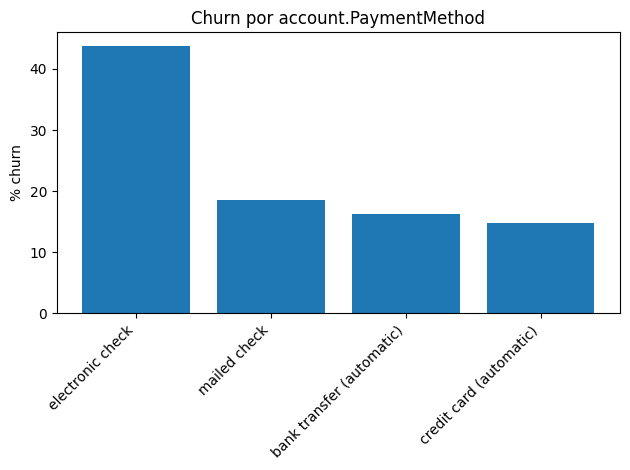

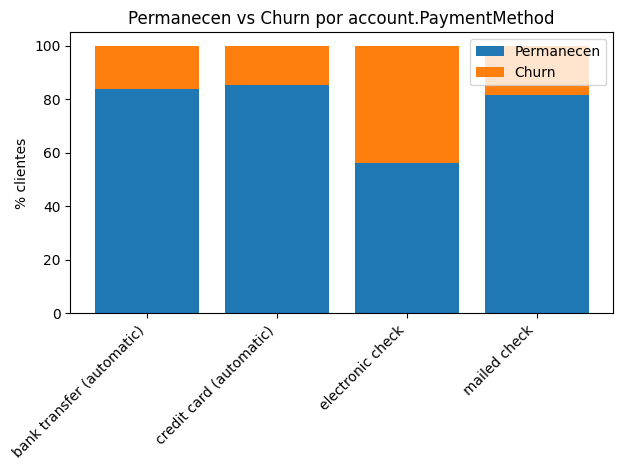

,% churn
account.PaperlessBilling,
yes,32.5
no,15.9


Churn_bin,Permanecen,Churn
account.PaperlessBilling,,
no,84.1,15.9
yes,67.5,32.5


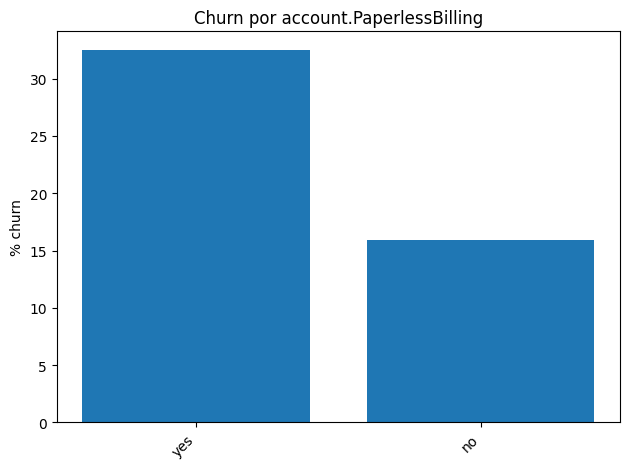

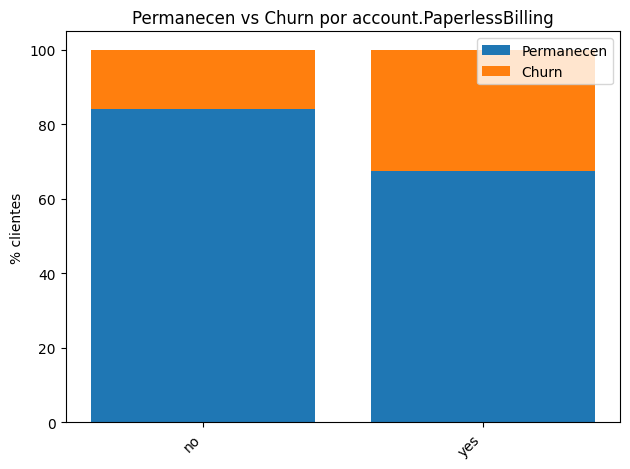

,% churn
internet.InternetService,
fiber optic,40.6
dsl,18.4
no,7.1


Churn_bin,Permanecen,Churn
internet.InternetService,,
dsl,81.6,18.4
fiber optic,59.4,40.6
no,92.9,7.1


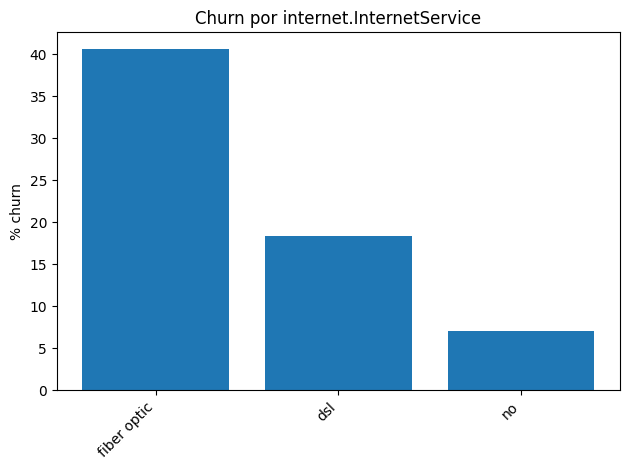

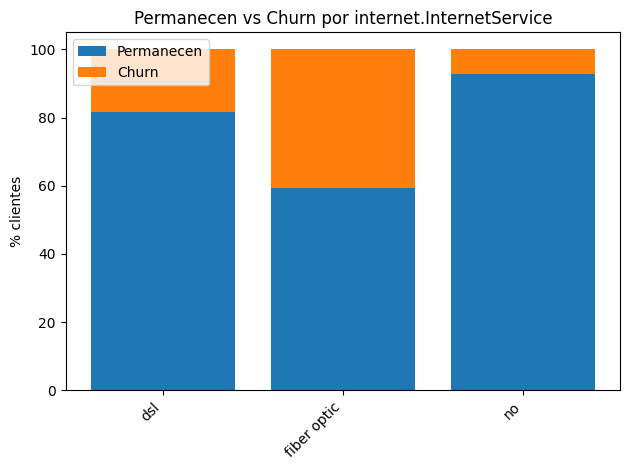

,% churn
internet.OnlineSecurity,
no,40.5
yes,14.2
no internet service,7.1


Churn_bin,Permanecen,Churn
internet.OnlineSecurity,,
no,59.5,40.5
no internet service,92.9,7.1
yes,85.8,14.2


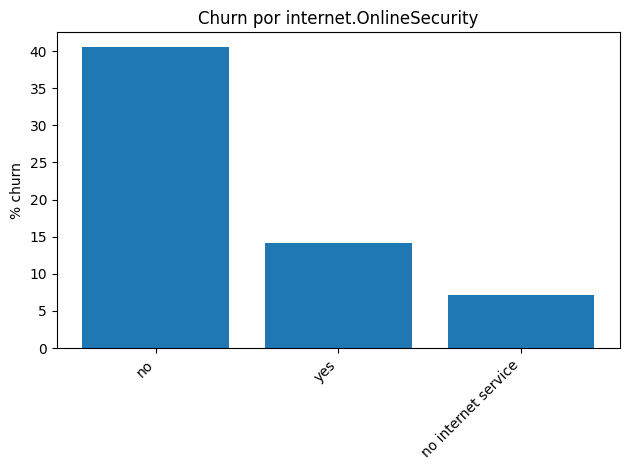

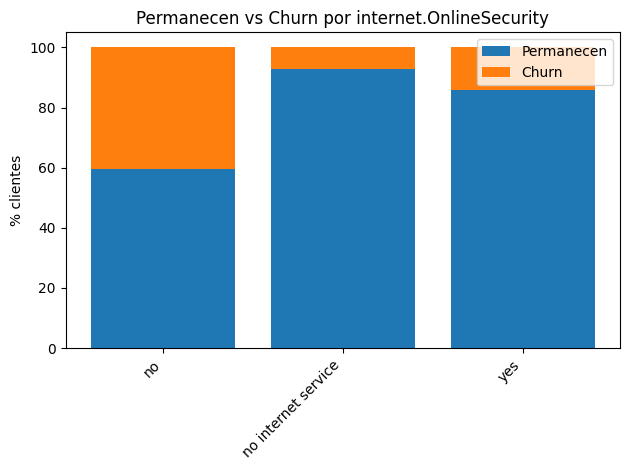

,% churn
internet.TechSupport,
no,40.4
yes,14.7
no internet service,7.1


Churn_bin,Permanecen,Churn
internet.TechSupport,,
no,59.6,40.4
no internet service,92.9,7.1
yes,85.3,14.7


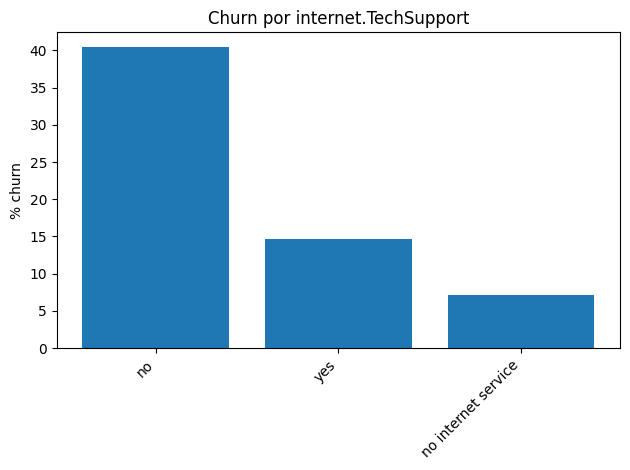

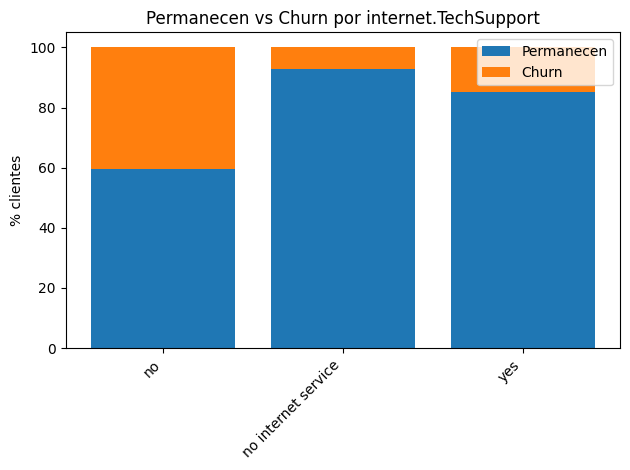


>>> customer.tenure
           count   mean  median    std  min  max
Churn_bin                                       
0           5398  37.32    37.0  24.18    0   72
1           1869  17.98    10.0  19.53    1   72


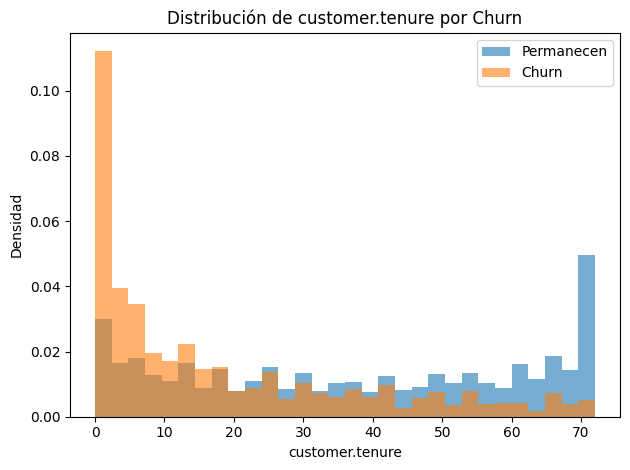

/tmp/ipython-input-4285577374.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


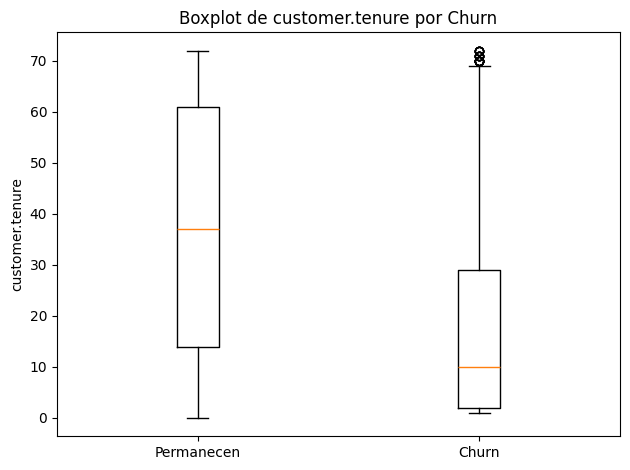


>>> account.Charges.Monthly
           count   mean  median    std    min     max
Churn_bin                                            
0           5398  61.35   64.50  31.11  18.25  118.75
1           1869  74.44   79.65  24.67  18.85  118.35


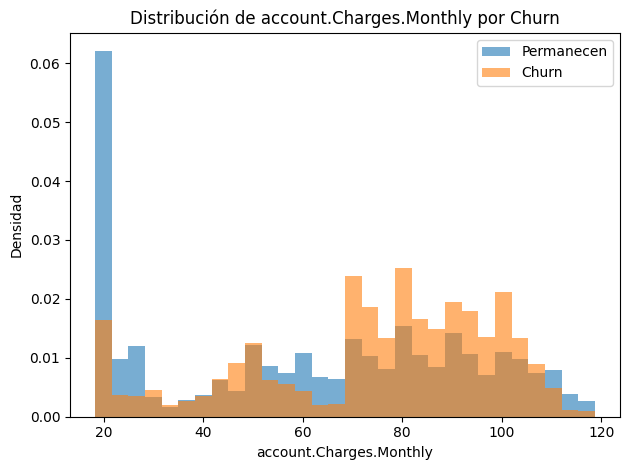

/tmp/ipython-input-4285577374.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


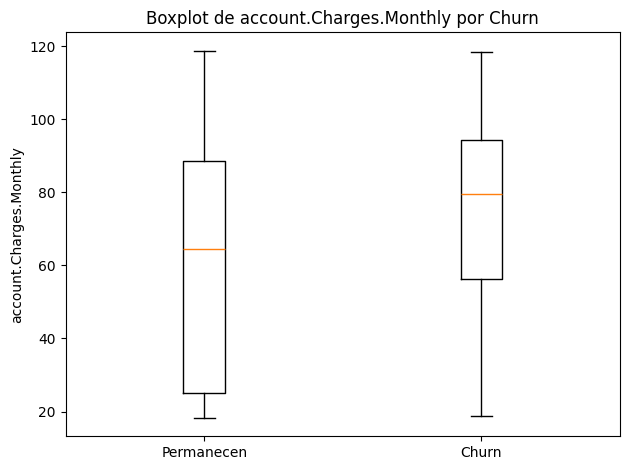


>>> account.Charges.Total
           count     mean   median      std    min      max
Churn_bin                                                  
0           5398  2535.26  1663.62  2330.80   0.00  8672.45
1           1869  1531.80   703.55  1890.82  18.85  8684.80


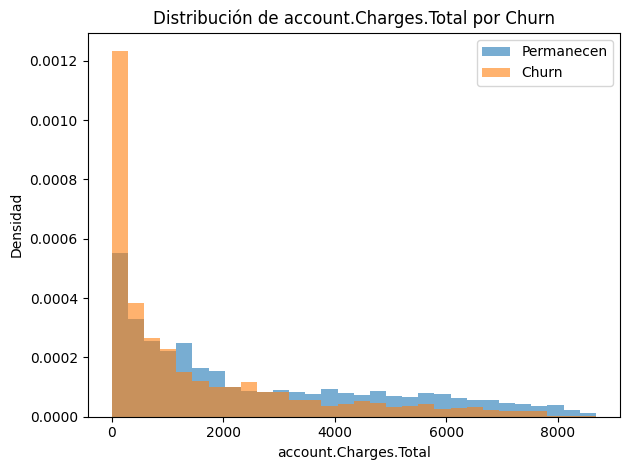

/tmp/ipython-input-4285577374.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


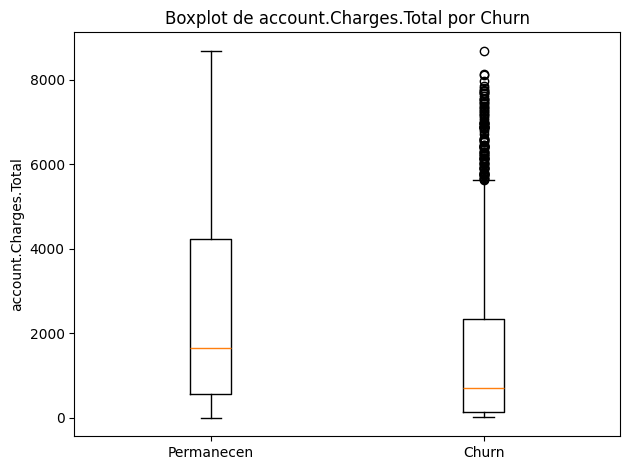


>>> Cuentas_Diarias
           count  mean  median   std   min   max
Churn_bin                                       
0           5398  2.02    2.12  1.02  0.60  3.90
1           1869  2.45    2.62  0.81  0.62  3.89


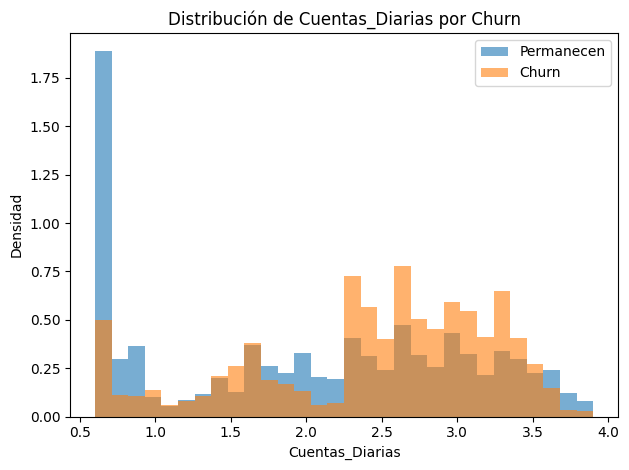

/tmp/ipython-input-4285577374.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


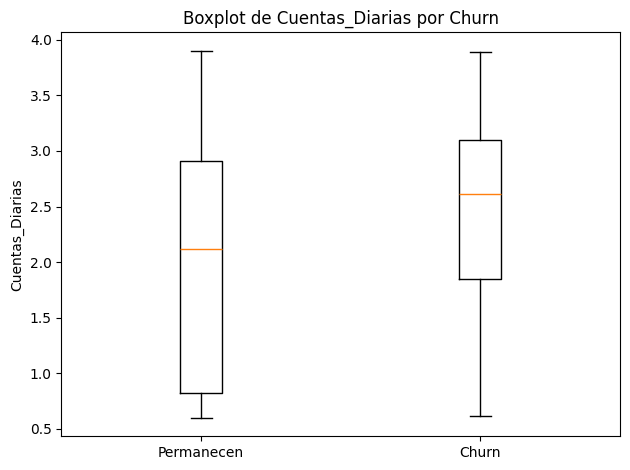


Top numéricas (|corr| con churn):
customer.tenure            0.344079
account.Charges.Total      0.193345
Cuentas_Diarias            0.189866
account.Charges.Monthly    0.189866
customer.SeniorCitizen     0.146733
dtype: float64

Top categóricas (lift de churn):
account.Contract             0.385695
internet.InternetService     0.334092
internet.OnlineSecurity      0.333460
internet.TechSupport         0.332211
internet.OnlineBackup        0.316018
internet.DeviceProtection    0.307556
account.PaymentMethod        0.290078
internet.StreamingMovies     0.255356
internet.StreamingTV         0.253802
account.PaperlessBilling     0.166090
dtype: float64


In [3]:
# ---- Descriptivo numérico (media/mediana/std...) ----
num_cols = df.select_dtypes(include='number').columns
desc_global = df[num_cols].describe().T
desc_por_churn = df.groupby('Churn_bin')[num_cols].agg(['mean', 'median', 'std', 'min', 'max'])

# ---- Distribución de churn (gráfico básico) ----
# Explicación: muestra cuántos clientes permanecen vs churn y su %.
counts = df['Churn_bin'].value_counts().reindex([0, 1], fill_value=0)
labels = ['Permanecen', 'Churn']
print("\nResumen churn (conteo y %):")
print(pd.DataFrame({'Clientes': counts.values,
                    '%': (counts.values / counts.sum() * 100).round(2)}, index=labels))

plt.figure()
plt.bar(labels, counts.values)
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v} ({v / counts.sum() * 100:.1f}%)", ha='center', va='bottom')
plt.title('Distribución de Churn')
plt.ylabel('Número de clientes')
plt.show()

# ---- Churn por variables categóricas ----
# Explicación: para cada categoría, calcula % de churn y la composición (stacked).
def churn_por_categoria(col):
    # % churn por categoría
    tasa = (df.groupby(col, observed=True)['Churn_bin'].mean()
              .mul(100).sort_values(ascending=False).round(1))
    display(tasa.rename('% churn'))

    # Composición (Permanecen vs Churn) normalizada por fila
    tab = (pd.crosstab(df[col], df['Churn_bin'], normalize='index')
             .mul(100).rename(columns={0:'Permanecen', 1:'Churn'}).round(1))
    display(tab)

    # Barras % churn
    plt.figure()
    plt.bar(tasa.index.astype(str), tasa.values)
    plt.ylabel('% churn'); plt.title(f'Churn por {col}')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    # Barras apiladas (composición)
    plt.figure()
    plt.bar(tab.index.astype(str), tab['Permanecen'].values, label='Permanecen')
    plt.bar(tab.index.astype(str), tab['Churn'].values, bottom=tab['Permanecen'].values, label='Churn')
    plt.ylabel('% clientes'); plt.title(f'Permanecen vs Churn por {col}')
    plt.xticks(rotation=45, ha='right'); plt.legend(); plt.tight_layout(); plt.show()

cat_for_plots = [
    'account.Contract','account.PaymentMethod','account.PaperlessBilling',
    'internet.InternetService','internet.OnlineSecurity','internet.TechSupport'
]
cat_for_plots = [c for c in cat_for_plots if c in df.columns]
for c in cat_for_plots:
    churn_por_categoria(c)

# ---- Numéricas por churn (hist y boxplot) ----
# Explicación: compara la forma de la distribución y los cuantiles por grupo.
num_vars = [c for c in ['customer.tenure','account.Charges.Monthly','account.Charges.Total','Cuentas_Diarias']
            if c in df.columns]

for col in num_vars:
    x0 = df.loc[df['Churn_bin']==0, col].dropna()
    x1 = df.loc[df['Churn_bin']==1, col].dropna()

    # Resumen por grupo (para leer medias/medianas rápidamente)
    print(f"\n>>> {col}")
    print(df.groupby('Churn_bin')[col].agg(['count','mean','median','std','min','max']).round(2))

    # Histograma superpuesto (misma escala de bins)
    bins = np.histogram_bin_edges(df[col].dropna(), bins=30)
    plt.figure()
    plt.hist(x0, bins=bins, alpha=0.6, density=True, label='Permanecen')
    plt.hist(x1, bins=bins, alpha=0.6, density=True, label='Churn')
    plt.title(f'Distribución de {col} por Churn')
    plt.xlabel(col); plt.ylabel('Densidad'); plt.legend()
    plt.tight_layout(); plt.show()

    # Boxplot por grupo (muestra mediana y dispersión)
    plt.figure()
    plt.boxplot([x0, x1], labels=['Permanecen','Churn'])
    plt.title(f'Boxplot de {col} por Churn'); plt.ylabel(col)
    plt.tight_layout(); plt.show()

# ---- Ranking rápido de relevancia ----
# Explicación: numéricas por correlación absoluta; categóricas por "lift" (max-min de tasa churn).
num_cols_corr = df.select_dtypes(include='number').columns.difference(['Churn_bin'])
top_num = df[num_cols_corr].corrwith(df['Churn_bin']).abs().sort_values(ascending=False)

cat_candidates = df.select_dtypes(include=['string','category','object']).columns.difference(['customerID','Churn'])
top_cat = pd.Series({
    c: (lambda s: s.max()-s.min())(df.groupby(c, observed=True)['Churn_bin'].mean())
    for c in cat_candidates
}).sort_values(ascending=False)

print("\nTop numéricas (|corr| con churn):")
print(top_num.head(10))
print("\nTop categóricas (lift de churn):")
print(top_cat.head(10))

# =========================================
#  Resume tasa de churn, hallazgos clave y pistas de acción
# =========================================

In [4]:
churn_rate = df['Churn_bin'].mean()*100
tenure_summary = df.groupby('Churn_bin')['customer.tenure'].median().to_dict()
by_contract = (df.groupby('account.Contract', observed=True)['Churn_bin']
                 .mean().mul(100).sort_values(ascending=False)).head(3)
by_payment  = (df.groupby('account.PaymentMethod', observed=True)['Churn_bin']
                 .mean().mul(100).sort_values(ascending=False)).head(3)

print("\n================  RESUMEN  ================")
print(f"Tasa global de churn: {churn_rate:.1f}%")
print(f"Mediana de tenure (0=Perm,1=Churn): {tenure_summary}")
print("Contratos con mayor % de churn:\n", by_contract.to_string())
print("Métodos de pago con mayor % de churn:\n", by_payment.to_string())
print("Pistas: foco en clientes 'month-to-month', pagos 'electronic check', y tenure bajo.\n"
      "Acciones sugeridas: onboarding y ofertas de retención en primeros meses; "
      "beneficios/seguridad en línea/soporte técnico para reducir churn en Internet.")


================  RESUMEN  ================
Tasa global de churn: 25.7%
Mediana de tenure (0=Perm,1=Churn): {0: 37.0, 1: 10.0}
Contratos con mayor % de churn:
 account.Contract
month-to-month    41.323346
one year          10.928242
two year           2.753873
Métodos de pago con mayor % de churn:
 account.PaymentMethod
electronic check             43.803681
mailed check                 18.498498
bank transfer (automatic)    16.236627
Pistas: foco en clientes 'month-to-month', pagos 'electronic check', y tenure bajo.
Acciones sugeridas: onboarding y ofertas de retención en primeros meses; beneficios/seguridad en línea/soporte técnico para reducir churn en Internet.


In [6]:
# Asegura que las columnas numéricas que vas a correlacionar sean realmente numéricas
for col in ['customer.tenure','account.Charges.Monthly','account.Charges.Total','Cuentas_Diarias']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # convierte '', ' ', etc. en NaN

# Ahora sí calcula las correlaciones de forma segura
num_corr = {}
for c in ['customer.tenure','account.Charges.Monthly','account.Charges.Total','Cuentas_Diarias']:
    if c in df.columns:
        num_corr[c] = df[c].corr(df['Churn_bin'])  # ya es numérico


In [8]:
# -- Asegurar columnas clave --
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

if 'Churn_bin' not in df.columns:
    df['Churn_bin'] = df['Churn'].astype(str).str.strip().str.lower().eq('yes').astype(int)

if 'Cuentas_Diarias' not in df.columns and 'account.Charges.Monthly' in df.columns:
    days_per_month = 365.25/12
    df['Cuentas_Diarias'] = df['account.Charges.Monthly'].fillna(0) / days_per_month

# -- Métricas síntesis para el informe --
churn_rate = df['Churn_bin'].mean()*100

tenure_median_0 = df.loc[df['Churn_bin']==0, 'customer.tenure'].median() if 'customer.tenure' in df else np.nan
tenure_median_1 = df.loc[df['Churn_bin']==1, 'customer.tenure'].median() if 'customer.tenure' in df else np.nan

m_monthly_0 = df.loc[df['Churn_bin']==0, 'account.Charges.Monthly'].mean() if 'account.Charges.Monthly' in df else np.nan
m_monthly_1 = df.loc[df['Churn_bin']==1, 'account.Charges.Monthly'].mean() if 'account.Charges.Monthly' in df else np.nan

def tasa_por(col):
    if col in df:
        return (df.groupby(col, observed=True)['Churn_bin'].mean().mul(100).sort_values(ascending=False))
    return pd.Series(dtype=float)

by_contract  = tasa_por('account.Contract').head(3)
by_payment   = tasa_por('account.PaymentMethod').head(3)
by_security  = tasa_por('internet.OnlineSecurity')

num_corr = {}
for c in ['customer.tenure','account.Charges.Monthly','account.Charges.Total','Cuentas_Diarias']:
    if c in df:
        num_corr[c] = df[c].corr(df['Churn_bin'])


#📄Informe final


# Informe Final — Telecom X · Análisis de Evasión (Churn)

## 🔹 Introducción
El objetivo de este análisis es **entender la evasión de clientes (churn)** en Telecom X para
apoyar decisiones de retención. A partir de los datos históricos de clientes, se exploran
patrones que ayuden a explicar **quiénes se dan de baja y por qué**.

## 🔹 Limpieza y Tratamiento de Datos
- **Extracción:** se montó Google Drive y se leyó un **JSON** con la base; el JSON venía anidado y
  se **aplanó** con `pd.json_normalize` (columnas como `account.Charges.Total`, `internet.OnlineSecurity`, etc.).
- **Tipificación:** `customerID` se dejó como texto; cargos mensuales/totales y `tenure` como numéricos.
- **Valores faltantes:** en `account.Charges.Total` se imputó **0** si `tenure=0` (cliente nuevo),
  y **`Monthly * tenure`** si `tenure>0`.
- **Variable objetivo:** `Churn_bin = 1` si `Churn == "yes"`, en otro caso `0`.
- **Derivada útil:** `Cuentas_Diarias = Monthly / 30.4375` para observar comportamiento a nivel diario.
- **Categorías:** limpieza ligera (minúsculas/espacios) y `category` para variables como contrato, método de pago
  y servicios de internet.

## 🔹 Análisis Exploratorio de Datos

**Distribución global de churn** (conteo y porcentaje):

,Clientes,%
Permanecen,5398,74.28
Churn,1869,25.72


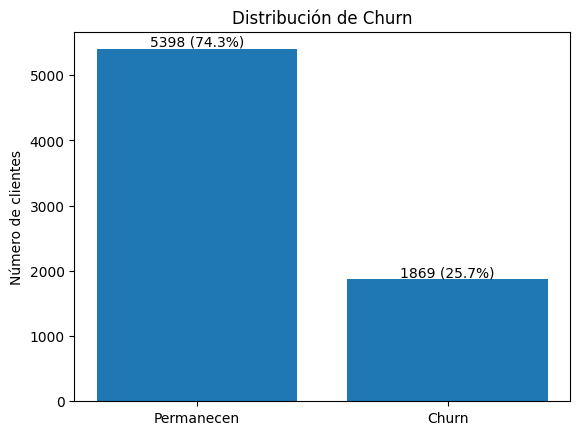

**Churn por `account.Contract`**

,% churn
account.Contract,
month-to-month,41.3
one year,10.9
two year,2.8


Composición (% clientes que permanecen vs churn):

Churn_bin,Permanecen,Churn
account.Contract,,
month-to-month,58.7,41.3
one year,89.1,10.9
two year,97.2,2.8


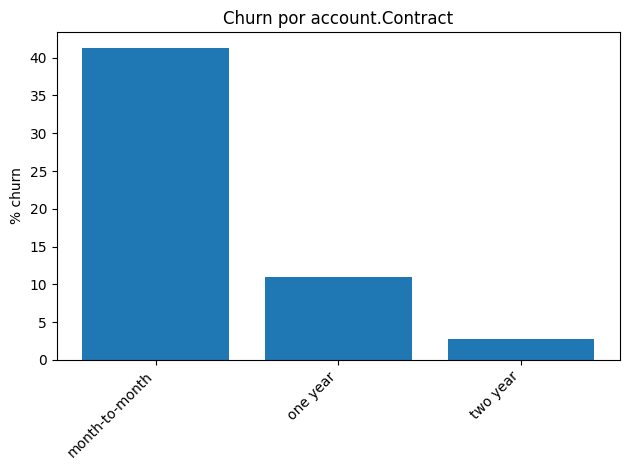

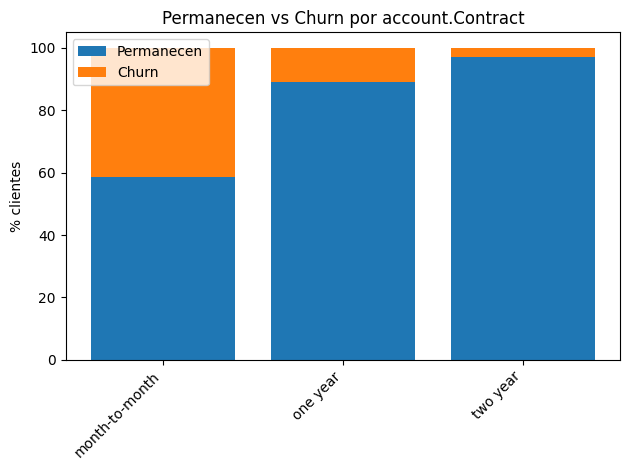

**Churn por `account.PaymentMethod`**

,% churn
account.PaymentMethod,
electronic check,43.8
mailed check,18.5
bank transfer (automatic),16.2
credit card (automatic),14.8


Composición (% clientes que permanecen vs churn):

Churn_bin,Permanecen,Churn
account.PaymentMethod,,
bank transfer (automatic),83.8,16.2
credit card (automatic),85.2,14.8
electronic check,56.2,43.8
mailed check,81.5,18.5


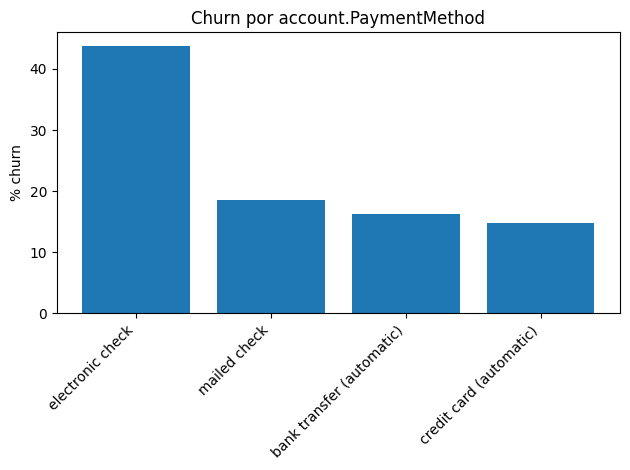

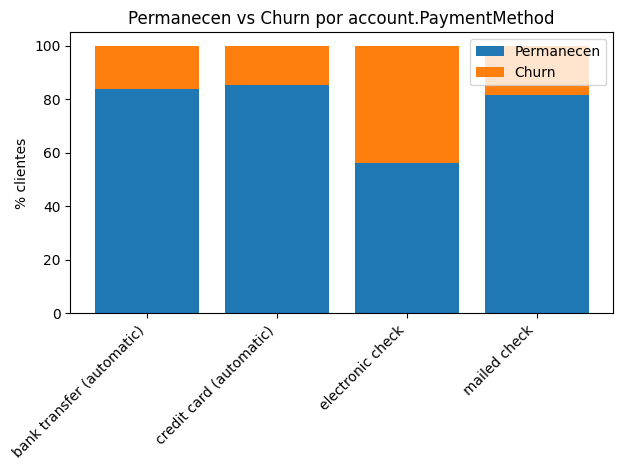

**Churn por `internet.OnlineSecurity`**

,% churn
internet.OnlineSecurity,
no,40.5
yes,14.2
no internet service,7.1


Composición (% clientes que permanecen vs churn):

Churn_bin,Permanecen,Churn
internet.OnlineSecurity,,
no,59.5,40.5
no internet service,92.9,7.1
yes,85.8,14.2


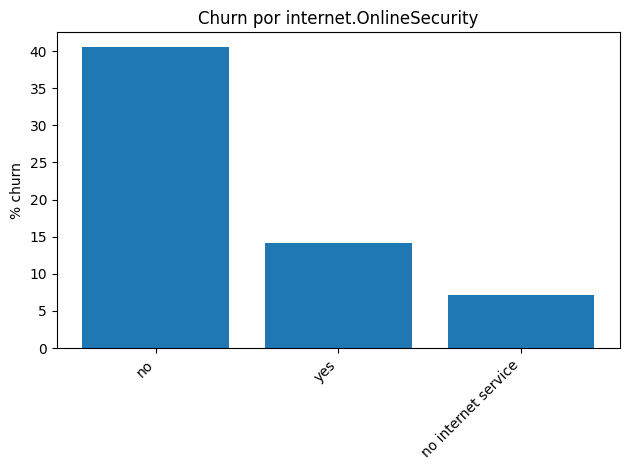

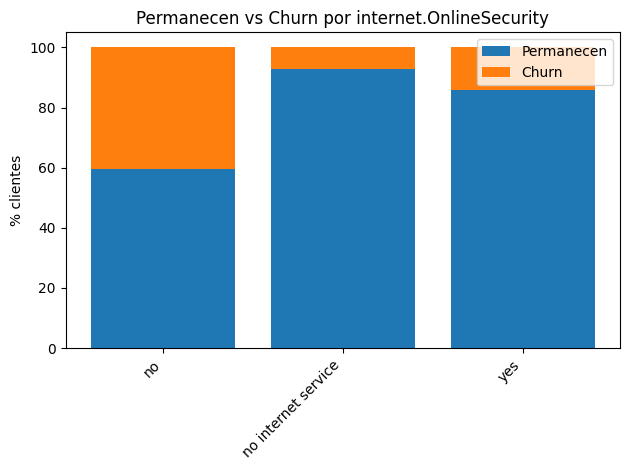

**Churn por `internet.TechSupport`**

,% churn
internet.TechSupport,
no,40.4
yes,14.7
no internet service,7.1


Composición (% clientes que permanecen vs churn):

Churn_bin,Permanecen,Churn
internet.TechSupport,,
no,59.6,40.4
no internet service,92.9,7.1
yes,85.3,14.7


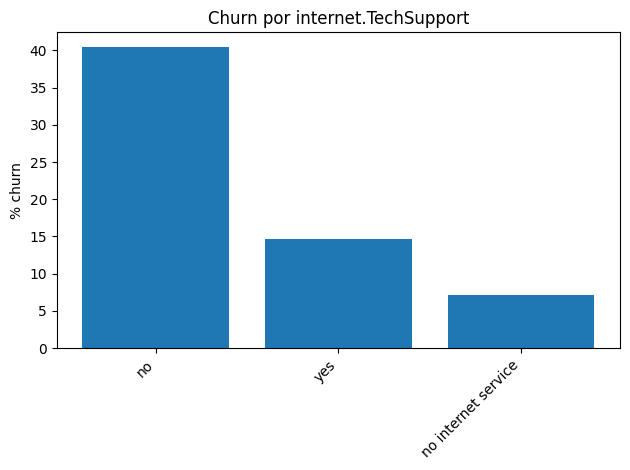

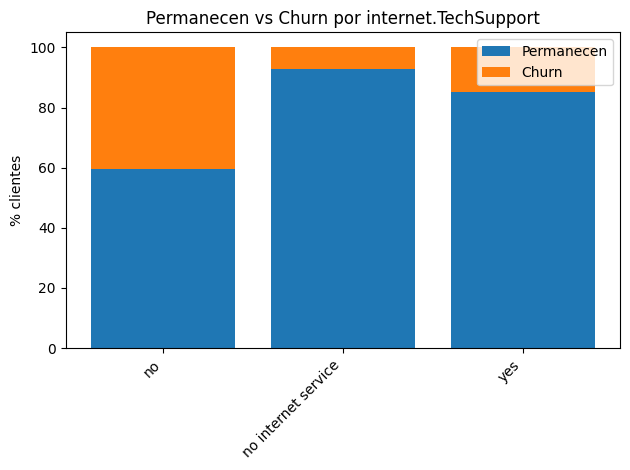

**Distribución de `customer.tenure` por churn**

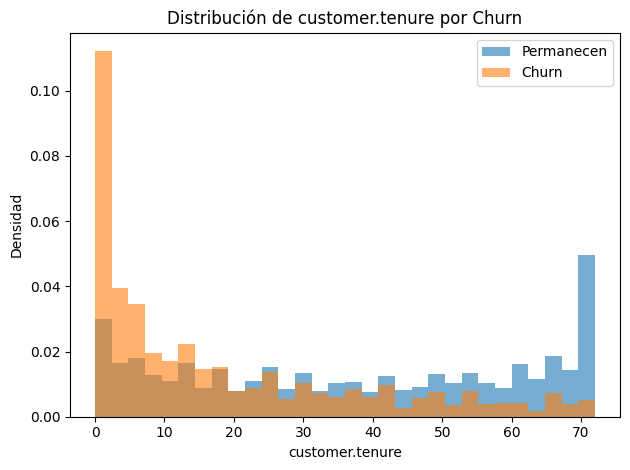

/tmp/ipython-input-1656755365.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


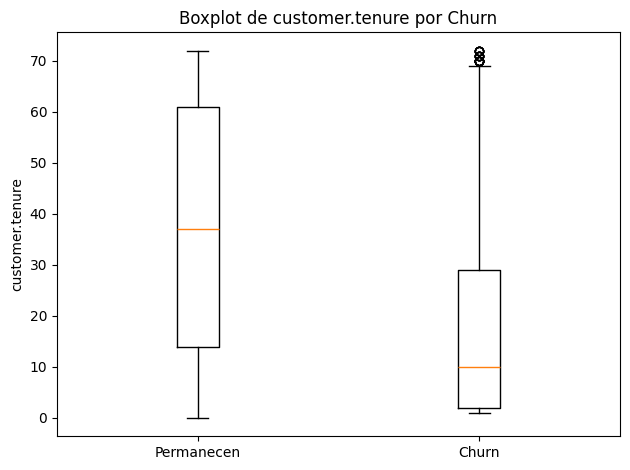

**Distribución de `account.Charges.Monthly` por churn**

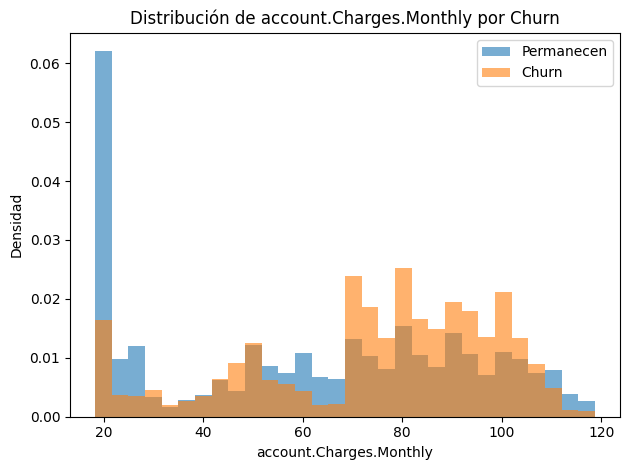

/tmp/ipython-input-1656755365.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


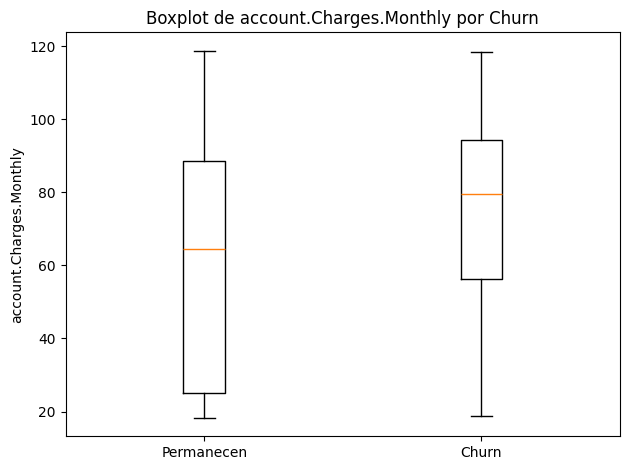

**Distribución de `account.Charges.Total` por churn**

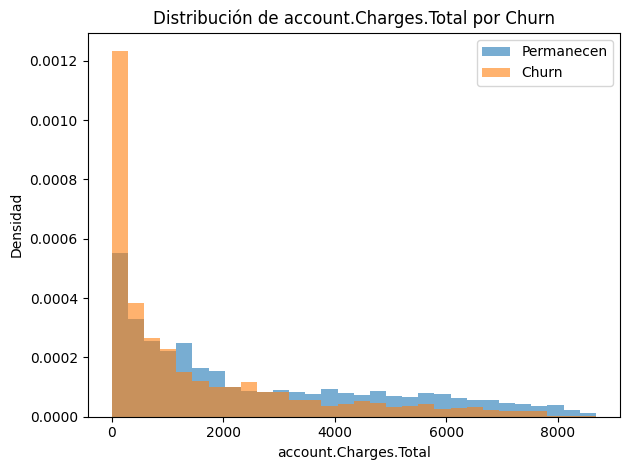

/tmp/ipython-input-1656755365.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


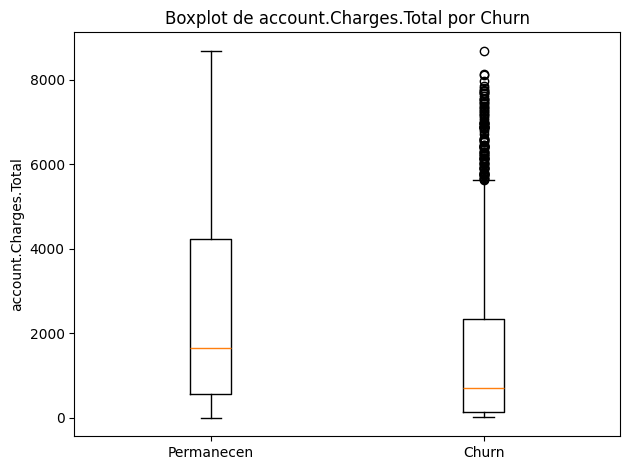

**Distribución de `Cuentas_Diarias` por churn**

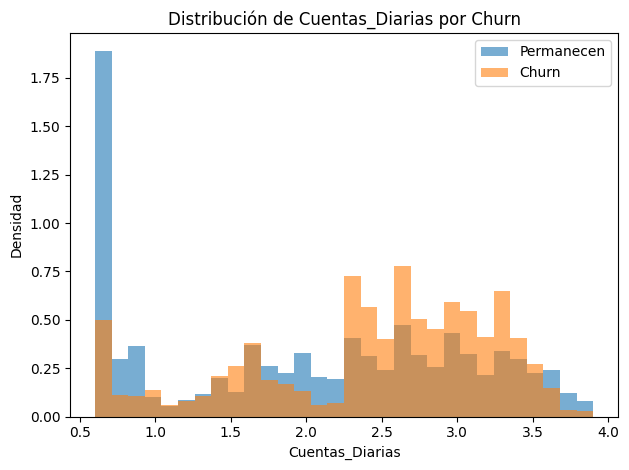

/tmp/ipython-input-1656755365.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=['Permanecen','Churn'])


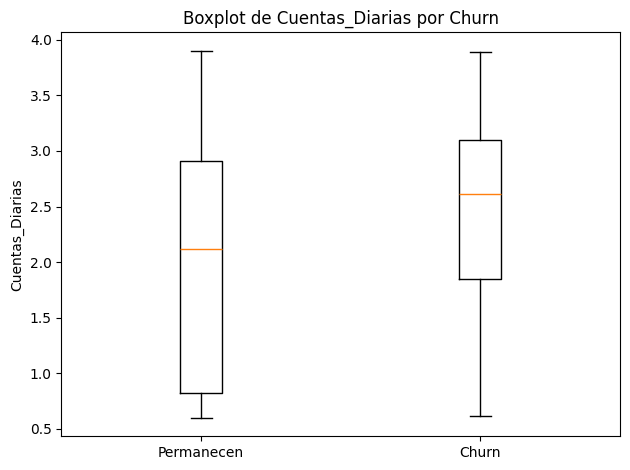

In [9]:
# ---- Resumen de churn (conteo y %) ----
counts = df['Churn_bin'].value_counts().reindex([0, 1], fill_value=0)
labels = ['Permanecen', 'Churn']
summary = pd.DataFrame({'Clientes': counts.values,
                        '%': (counts.values / counts.sum() * 100).round(2)}, index=labels)

display(Markdown("## 🔹 Análisis Exploratorio de Datos"))
display(Markdown("**Distribución global de churn** (conteo y porcentaje):"))
display(summary)

plt.figure()
plt.bar(labels, counts.values)
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v} ({v / counts.sum() * 100:.1f}%)", ha='center', va='bottom')
plt.title('Distribución de Churn')
plt.ylabel('Número de clientes')
plt.show()

# ---- Churn por variables categóricas clave ----
def graf_cat(col):
    if col not in df:
        return
    display(Markdown(f"**Churn por `{col}`**"))
    tasa = (df.groupby(col, observed=True)['Churn_bin'].mean()
              .mul(100).sort_values(ascending=False).round(1))
    display(tasa.rename('% churn'))

    tab = (pd.crosstab(df[col], df['Churn_bin'], normalize='index')
             .mul(100).rename(columns={0:'Permanecen',1:'Churn'}).round(1))
    display(Markdown("Composición (% clientes que permanecen vs churn):"))
    display(tab)

    plt.figure()
    plt.bar(tasa.index.astype(str), tasa.values)
    plt.ylabel('% churn'); plt.title(f'Churn por {col}')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    plt.figure()
    plt.bar(tab.index.astype(str), tab['Permanecen'].values, label='Permanecen')
    plt.bar(tab.index.astype(str), tab['Churn'].values, bottom=tab['Permanecen'].values, label='Churn')
    plt.ylabel('% clientes'); plt.title(f'Permanecen vs Churn por {col}')
    plt.xticks(rotation=45, ha='right'); plt.legend(); plt.tight_layout(); plt.show()

for c in ['account.Contract','account.PaymentMethod','internet.OnlineSecurity','internet.TechSupport']:
    graf_cat(c)

# ---- Numéricas por churn (hist + boxplot) ----
def graf_num(col):
    if col not in df:
        return
    x0 = df.loc[df['Churn_bin']==0, col].dropna()
    x1 = df.loc[df['Churn_bin']==1, col].dropna()

    display(Markdown(f"**Distribución de `{col}` por churn**"))
    bins = np.histogram_bin_edges(df[col].dropna(), bins=30)
    plt.figure()
    plt.hist(x0, bins=bins, alpha=0.6, density=True, label='Permanecen')
    plt.hist(x1, bins=bins, alpha=0.6, density=True, label='Churn')
    plt.xlabel(col); plt.ylabel('Densidad'); plt.title(f'Distribución de {col} por Churn'); plt.legend()
    plt.tight_layout(); plt.show()

    plt.figure()
    plt.boxplot([x0, x1], labels=['Permanecen','Churn'])
    plt.ylabel(col); plt.title(f'Boxplot de {col} por Churn')
    plt.tight_layout(); plt.show()

for c in ['customer.tenure','account.Charges.Monthly','account.Charges.Total','Cuentas_Diarias']:
    graf_num(c)


In [10]:
# Construir bullets con datos reales de tu DF
def fmt_top(s):
    if s is None or s.empty: return "s/d"
    return ", ".join([f"{k} ({v:.1f}%)" for k, v in s.items()])

corr_tenure  = num_corr.get('customer.tenure', np.nan)
corr_monthly = num_corr.get('account.Charges.Monthly', np.nan)
corr_total   = num_corr.get('account.Charges.Total', np.nan)

md_conclusions = f"""
## 🔹 Conclusiones e Insights

- La **tasa global de churn** es **{churn_rate:.1f}%**.
- Los clientes que se van tienen **tenure** mediano **{tenure_median_1:.0f}** meses vs **{tenure_median_0:.0f}** en quienes permanecen → **antigüedad baja** se asocia a mayor churn.
- **Cargos mensuales** promedio: *perm.* **{m_monthly_0:.2f}** vs *churn* **{m_monthly_1:.2f}**. La correlación con churn es **{corr_monthly:.2f}** (signo positivo = mayor cargo → mayor churn).
- **Relación numérica (correlación con churn)**:
  - tenure: **{corr_tenure:.2f}** (negativa → a mayor tenure, menor churn)
  - monthly: **{corr_monthly:.2f}**
  - total: **{corr_total:.2f}**
- **Categorías con mayor % de churn**:
  - Contrato: {fmt_top(by_contract)}
  - Método de pago: {fmt_top(by_payment)}
  - OnlineSecurity: {fmt_top(by_security)}

**Lectura general:** mayor churn en clientes **recién incorporados**, en **contratos month-to-month**, con **electronic check**, y en perfiles **sin online security/tech support**. Cargos mensuales más altos también muestran tendencia a elevar el churn.
"""
display(Markdown(md_conclusions))



## 🔹 Conclusiones e Insights

- La **tasa global de churn** es **25.7%**.
- Los clientes que se van tienen **tenure** mediano **10** meses vs **37** en quienes permanecen → **antigüedad baja** se asocia a mayor churn.
- **Cargos mensuales** promedio: *perm.* **61.35** vs *churn* **74.44**. La correlación con churn es **0.19** (signo positivo = mayor cargo → mayor churn).
- **Relación numérica (correlación con churn)**:
  - tenure: **-0.34** (negativa → a mayor tenure, menor churn)
  - monthly: **0.19**
  - total: **-0.19**
- **Categorías con mayor % de churn**:
  - Contrato: month-to-month (41.3%), one year (10.9%), two year (2.8%)
  - Método de pago: electronic check (43.8%), mailed check (18.5%), bank transfer (automatic) (16.2%)
  - OnlineSecurity: no (40.5%), yes (14.2%), no internet service (7.1%)

**Lectura general:** mayor churn en clientes **recién incorporados**, en **contratos month-to-month**, con **electronic check**, y en perfiles **sin online security/tech support**. Cargos mensuales más altos también muestran tendencia a elevar el churn.


## 🔹 Recomendaciones

1. **Primeros meses críticos:** programa de *onboarding* y beneficios progresivos durante los 3–6 primeros meses (bonos, soporte prioritario).
2. **Migración de contrato:** incentivar el paso de **month-to-month** a **1/2 años** (descuentos por permanencia, bundles de servicios).
3. **Medios de pago:** promover **autopago / tarjeta** en lugar de *electronic check* (bonificación por activación).
4. **Servicios de valor (retención):** campañas para activar **online security** y **tech support**, especialmente en clientes en riesgo.
5. **Segmento de alto riesgo:** monitorear y contactar proactivamente a clientes con **tenure bajo + monthly alto**.
6. **Pruebas A/B y seguimiento:** medir impacto de descuentos/bonos sobre la **tasa de churn** y el **LTV**; ajustar según resultados.
"""
display(Markdown(md_recos))
